## Setup

In [1]:
import os

In [2]:
try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = False
print(IN_COLAB)

True


In [3]:
!pip install graph_nets  dm-sonnet tensorflow_probability

In [4]:
if IN_COLAB and 'drive' not in os.listdir("/content"):
    from google.colab import drive

    drive.mount('/content/drive')

In [5]:
if IN_COLAB:
    os.chdir('/content/drive/MyDrive/bakalarka')

In [6]:
import tensorflow as tf

import functools
import json
import os

import time
import sys
import re

from graph_nets import utils_tf


In [7]:
params = dict(noise=0.02, gamma=1.0, field='velocity', history=False,
              size=2, batch=2)

In [8]:
from common import NodeType

## Data Loading

In [9]:
data_path = 'data/airfoil'
data_train = 'small' if IN_COLAB else 'train'
data_valid = 'small' if IN_COLAB else 'valid'
data_test = 'small' if IN_COLAB else 'test'

In [10]:
# todo add citation
def _parse(proto, meta):
    """Parses a trajectory from tf.Example."""
    feature_lists = {k: tf.io.VarLenFeature(tf.string)
                     for k in meta['field_names']}
    features = tf.io.parse_single_example(proto, feature_lists)
    out = {}
    for key, field in meta['features'].items():
        data = tf.io.decode_raw(features[key].values, getattr(tf, field['dtype']))
        data = tf.reshape(data, field['shape'])
        if field['type'] == 'static':
            data = tf.tile(data, [meta['trajectory_length'], 1, 1])
        elif field['type'] == 'dynamic_varlen':
            length = tf.io.decode_raw(features['length_' + key].values, tf.int32)
            length = tf.reshape(length, [-1])
            data = tf.RaggedTensor.from_row_lengths(data, row_lengths=length)
        elif field['type'] != 'dynamic':
            raise ValueError('invalid data format')
        out[key] = data
    return out

In [11]:
# todo add citation
def load_dataset(path, split):
    """Load dataset."""
    with open(os.path.join(path, 'meta.json'), 'r') as fp:
        meta = json.loads(fp.read())
    ds = tf.data.TFRecordDataset(os.path.join(path, split + '.tfrecord'))
    ds = ds.map(functools.partial(_parse, meta=meta), num_parallel_calls=8)
    ds = ds.prefetch(1)
    return ds

In [12]:
# todo add citation
shuffle = 100 if IN_COLAB else 10000
def split_and_preprocess(ds, noise_field, noise_scale, noise_gamma):
    """Splits trajectories into frames, and adds training noise."""

    def add_noise(frame):
        noise = tf.random.normal(tf.shape(frame[noise_field]),
                                 stddev=noise_scale, dtype=tf.float32)
        # don't apply noise to boundary nodes
        mask = tf.equal(frame['node_type'], NodeType.NORMAL)
        noise = tf.where(mask, noise, tf.zeros_like(noise))
        frame[noise_field] += noise
        frame['target|' + noise_field] += (1.0 - noise_gamma) * noise
        return frame

    ds = ds.flat_map(tf.data.Dataset.from_tensor_slices)
    ds = ds.map(add_noise, num_parallel_calls=8)
    ds = ds.shuffle(shuffle)
    ds = ds.repeat(None)
    return ds.prefetch(10)

In [13]:
# todo add citation
def add_targets(ds, fields, add_history):
    """Adds target and optionally history fields to dataframe."""

    def fn(trajectory):
        out = {}
        for key, val in trajectory.items():
            out[key] = val[1:-1]
            if key in fields:
                if add_history:
                    out['prev|' + key] = val[0:-2]
                out['target|' + key] = val[2:]
        return out

    return ds.map(fn, num_parallel_calls=8)

In [14]:
def add_batch(ds, b_size):
  nodes = ds.element_spec["node_type"].shape[0]

  def batch(item):
    out = {}
    for key,val in item.items():
      if key == 'cells':
        out[key] = tf.concat([val[x] + x*nodes for x in range(val.shape[0])],axis=0) 
      else:
        out[key] = tf.reshape(val, [-1,val.shape[2]])
    return out

  ds = ds.batch(b_size,True)
  return ds.map(batch, num_parallel_calls=8)

In [15]:
ds = load_dataset(data_path, data_train)
ds = add_targets(ds, [params['field']], add_history=params['history'])

In [16]:
ds = split_and_preprocess(ds, noise_field=params['field'],
                          noise_scale=params['noise'],
                          noise_gamma=params['gamma'])

In [17]:
ds = add_batch(ds,params['batch'])

## Prepare for learning

In [18]:
itr = iter(ds)
d = itr.next()

In [19]:
def triangles_to_edges(faces):
    """Computes mesh edges from triangles."""
    # collect edges from triangles
    edges = tf.concat([faces[:, 0:2],
                       faces[:, 1:3],
                       tf.stack([faces[:, 2], faces[:, 0]], axis=1)], axis=0)
    # those edges are sometimes duplicated (within the mesh) and sometimes
    # single (at the mesh boundary).
    # sort & pack edges as single tf.int64
    receivers = tf.reduce_min(edges, axis=1)
    senders = tf.reduce_max(edges, axis=1)
    packed_edges = tf.bitcast(tf.stack([senders, receivers], axis=1), tf.int64)
    # remove duplicates and unpack
    unique_edges = tf.bitcast(tf.unique(packed_edges)[0], tf.int32)
    senders, receivers = tf.unstack(unique_edges, axis=1)
    # create two-way connectivity
    return (tf.concat([senders, receivers], axis=0),
            tf.concat([receivers, senders], axis=0))


In [20]:
NodeTypeCnt = tf.unique(tf.reshape(d['node_type'], d['node_type'].shape[:1])).y.shape[0]

In [21]:
@tf.function
def toGraphsTuple(d):
    send, recive = triangles_to_edges(d['cells'])
    rel_pos = (tf.gather(d['mesh_pos'], send) - tf.gather(d['mesh_pos'], recive))
    nodes_unique = tf.unique_with_counts(tf.reshape(d["node_type"], [-1]))
    one_hot = tf.one_hot(nodes_unique.idx, NodeTypeCnt, dtype=tf.float32)
    dd = {
          #"nodes": tf.concat([d["velocity"],d["pressure"],d["density"],tf.cast(d["node_type"],tf.float32),d["mesh_pos"]],1),
          "nodes": tf.concat([d['velocity'], one_hot], 1),
          # on change update loss function ^
          "senders": send,
          "receivers": recive,
          "edges": tf.concat([
              rel_pos,
              tf.norm(rel_pos, axis=-1, keepdims=True)], 1)
      }
    return utils_tf.data_dicts_to_graphs_tuple([dd])

In [22]:
dd = toGraphsTuple(d)
LINEAR_FEATURES = dd.nodes.shape[1] - NodeTypeCnt

In [23]:
dd

GraphsTuple(nodes=<tf.Tensor: shape=(10466, 5), dtype=float32, numpy=
array([[263.21005 ,  33.635777,   1.      ,   0.      ,   0.      ],
       [252.48123 ,  36.677284,   1.      ,   0.      ,   0.      ],
       [258.0215  ,  37.294044,   1.      ,   0.      ,   0.      ],
       ...,
       [257.07712 ,  74.71529 ,   0.      ,   0.      ,   1.      ],
       [257.07413 ,  74.77687 ,   0.      ,   0.      ,   1.      ],
       [257.08728 ,  74.73272 ,   0.      ,   0.      ,   1.      ]],
      dtype=float32)>, edges=<tf.Tensor: shape=(61796, 3), dtype=float32, numpy=
array([[ 0.00579996, -0.01206488,  0.01338659],
       [-0.00720367, -0.01440071,  0.01610196],
       [-0.00630522,  0.0145334 ,  0.0158422 ],
       ...,
       [ 0.30951977,  1.4802246 ,  1.5122392 ],
       [ 1.0828505 ,  1.8325498 ,  2.1285684 ],
       [-0.43042946,  1.2830333 ,  1.3533084 ]], dtype=float32)>, receivers=<tf.Tensor: shape=(61796,), dtype=int32, numpy=array([   69,    55,   159, ..., 10294, 10339, 

In [24]:
aa = itr.next()

## Model and loss function

In [25]:
from EncodeProcessDecodeBasic import EncodeProcessDecode

In [26]:
from EncodeProcessDecodeNorm import EncodeProcessDecode as EncodeProcessDecodeNorm

In [27]:
from EncodeProcessDecodeAddNorm import EncodeProcessDecode as EncodeProcessDecodeAddNorm

In [28]:
from EncodeProcessDecodeNoLib import EncodeProcessDecode as EncodeProcessDecodeNoLib

In [29]:
from EncodeProcessDecodeMultinet import EncodeProcessDecode as EncodeProcessDecodeMultinet

In [30]:
from EncodeProcessDecodeNamedMultinet import EncodeProcessDecode as EncodeProcessDecodeNamedMultinet

In [31]:
models = {"basic": {"model": EncodeProcessDecode,
                    "args": {"steps": 15,
                             "learn_features": 2,
                             "node_net_sizes": [128] * 2 + [2],
                             "edge_net_sizes": [128] * 2 + [4]}},
          "small_test": {"model": EncodeProcessDecode,
                         "args": {"steps": 5,
                                  "learn_features": 2,
                                  "node_net_sizes": [8] * 2 + [2],
                                  "edge_net_sizes": [8] * 2 + [4]}},
          "full": {"model": EncodeProcessDecodeNorm,
                   "args": {"steps": 15,
                            "learn_features": 2,
                            "n_layers": 2,
                            "lat_size": 128,
                            "edge_feat_cnt": 3,
                            "node_feat_cnt": 5}},
          "no-norm": {"model": EncodeProcessDecodeNorm,
                      "args": {"steps": 15,
                               "learn_features": 2,
                               "n_layers": 2,
                               "lat_size": 128,
                               "edge_feat_cnt": 3,
                               "node_feat_cnt": 5,
                               "la_norm": False}},
          "add": {"model": EncodeProcessDecodeAddNorm,
                  "args": {"steps": 15,
                           "learn_features": 2,
                           "n_layers": 2,
                           "lat_size": 128,
                           "edge_feat_cnt": 3,
                           "node_feat_cnt": 5}},
          "no-lib": {"model": EncodeProcessDecodeNoLib,
                     "args": {"steps": 15,
                              "learn_features": 2,
                              "n_layers": 2,
                              "lat_size": 128,
                              "edge_feat_cnt": 3,
                              "node_feat_cnt": 5}},
          "multinet": {"model": EncodeProcessDecodeMultinet,
                       "args": {"steps": 15,
                                "learn_features": 2,
                                "n_layers": 2,
                                "lat_size": 128,
                                "edge_feat_cnt": 3,
                                "node_feat_cnt": 5}},
          "named": {"model": EncodeProcessDecodeNamedMultinet,
                       "args": {"steps": 15,
                                "learn_features": 2,
                                "n_layers": 2,
                                "lat_size": 128,
                                "edge_feat_cnt": 3,
                                "node_feat_cnt": 5}}}

### Model hyperparameters

In [32]:
from AdamModLr import Adam

lr = 1e-4
# opt = snt.optimizers.Adam(lr)
opt = Adam(lr)
steps = 15
#model = EncodeProcessDecode(steps, LINEAR_FEATURES, [128] * 2, [128] * 2 + [4])
mod = "named"
md = models[mod]
model = md["model"](**md["args"])
initial_learning_rate = lr
decay_rate = 0.1
decay_steps = 5e6
learning_increase = 1e-6

## Training

In [33]:
def decayed_learning_rate(step):
    return initial_learning_rate * decay_rate ** (step / decay_steps) + learning_increase

In [34]:
@tf.function
def update_step(data):
    print("Tracing!")
    grp = toGraphsTuple(data)
    with tf.GradientTape() as tape:
        los = model.loss(grp, data)  #change to loss

    gradients = tape.gradient(los, model.trainable_variables)

    opt.apply(gradients, model.trainable_variables)
    return los

In [35]:
tf.concat([x['velocity'] for x in [aa,aa]],axis=0)

<tf.Tensor: shape=(20932, 2), dtype=float32, numpy=
array([[247.36261 ,  31.937376],
       [246.59071 ,  35.58513 ],
       [253.40872 ,  36.568577],
       ...,
       [257.08728 ,  74.76753 ],
       [257.11084 ,  74.74221 ],
       [257.06497 ,  74.76649 ]], dtype=float32)>

In [36]:
update_step(aa);

Tracing!
Tracing!


In [37]:
@tf.function
def loss(grp, data):
    return model.loss(grp, data)


In [38]:
if IN_COLAB:
    logdir = 'logs/tst/'
    writer = tf.summary.create_file_writer(logdir)

    # Bracket the function call with
    # tf.summary.trace_on() and tf.summary.trace_export().
    tf.summary.trace_on(graph=True, profiler=True)
    # Call only one tf.function when tracing.
    z = loss(dd, d);
    with writer.as_default():
        tf.summary.trace_export(
            name="my_func_trace",
            step=0,
            profiler_outdir=logdir)

Instructions for updating:
use `tf.profiler.experimental.start` instead.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
Instructions for updating:
`tf.python.eager.profiler` has deprecated, use `tf.profiler` instead.
Instructions for updating:
`tf.python.eager.profiler` has deprecated, use `tf.profiler` instead.


In [39]:
chck_root = "models/namednet/"
chck_name = mod

chck = tf.train.Checkpoint(module=model)

latest = tf.train.latest_checkpoint(chck_root)
if latest is not None:
    print("loading", latest)
    chck.restore(latest)

loading models/namednet/named-156


In [40]:
if latest is None and not isinstance(model, EncodeProcessDecode):
    print("Acumulating")
    for i in range(1000):
        data = itr.next()
        grp = toGraphsTuple(data)
        model.loss(grp, data)

In [41]:
colab_train = False
start = 0
sm_print = 500
save_itr = 40000
if not IN_COLAB or colab_train:
    if latest is not None:
        start = int(re.findall('\d+$', latest)[0]) * save_itr
    t = time.time()
    print("training")
    sys.stdout.flush()
    for i in range(start, int(1e7)+1):
        a = itr.next()
        m = update_step(a)
        if i % sm_print == 0:
            opt.learning_rate.assign(decayed_learning_rate(i))
            print("i", i, "mse:", m.numpy())
            if i and i % save_itr == 0:
                sys.stdout.flush()
                chck.save(chck_root + chck_name)
    print(time.time() - t)

In [42]:
if "m" in locals():
    m.numpy()

## Vizualization

In [43]:
dt2 = load_dataset(data_path, data_valid)
dt2 = add_targets(dt2, [params['field']], add_history=params['history'])
qq = iter(dt2).next()
qqq = {}
for i, j in qq.items():
    qqq[i] = j[0]
grp_ = toGraphsTuple(qqq)

In [44]:
@tf.function
def toGraphsTupleOld(d):
    send, recive = triangles_to_edges(d['cells'])
    rel_pos = (tf.gather(d['mesh_pos'], send) - tf.gather(d['mesh_pos'], recive))
    nodes_unique = tf.unique_with_counts(tf.reshape(d["node_type"], [-1]))
    dd = {
        #"nodes": tf.concat([d["velocity"],d["pressure"],d["density"],tf.cast(d["node_type"],tf.float32),d["mesh_pos"]],1),
        "nodes": tf.concat([d['velocity'], tf.one_hot(tf.reshape(d["node_type"], [-1]), NodeTypeCnt, dtype=tf.float32)],
                           1),  # on change update loss function ^
        "senders": send,
        "receivers": recive,
        "edges": tf.concat([
            rel_pos,
            tf.norm(rel_pos, axis=-1, keepdims=True)], 1)
    }
    return utils_tf.data_dicts_to_graphs_tuple([dd])

In [45]:
# fix mistake in data preparation
if chck_root == "models/new":
    grp_ = toGraphsTupleOld(qqq)

In [46]:
res = [grp_, ]
loss_mask = tf.logical_or(tf.equal(qqq['node_type'][:, 0], NodeType.NORMAL),
                          tf.equal(qqq['node_type'][:, 0], NodeType.OUTFLOW))
loss_mask = tf.reshape(tf.concat([loss_mask for _ in range(5)], -1), [-1, 5])
for i in range(600):
    grp2_ = model(grp_, False)
    grp_ = grp_.replace(nodes=tf.where(loss_mask, grp2_.nodes, grp_.nodes))
    res.append(grp_)

In [47]:
grp_.nodes.shape, grp2_.nodes.shape, loss_mask.shape

(TensorShape([5233, 5]), TensorShape([5233, 5]), TensorShape([5233, 5]))

In [48]:
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import tri as mtri

In [49]:
res[0]

GraphsTuple(nodes=<tf.Tensor: shape=(5233, 5), dtype=float32, numpy=
array([[334.88293 ,  44.354774,   1.      ,   0.      ,   0.      ],
       [304.09152 ,  44.64592 ,   1.      ,   0.      ,   0.      ],
       [306.3374  ,  44.501225,   1.      ,   0.      ,   0.      ],
       ...,
       [257.09155 ,  74.75611 ,   0.      ,   0.      ,   1.      ],
       [257.09155 ,  74.75611 ,   0.      ,   0.      ,   1.      ],
       [257.09155 ,  74.75611 ,   0.      ,   0.      ,   1.      ]],
      dtype=float32)>, edges=<tf.Tensor: shape=(30898, 3), dtype=float32, numpy=
array([[ 0.00579996, -0.01206488,  0.01338659],
       [-0.00720367, -0.01440071,  0.01610196],
       [-0.00630522,  0.0145334 ,  0.0158422 ],
       ...,
       [ 0.30951977,  1.4802246 ,  1.5122392 ],
       [ 1.0828505 ,  1.8325498 ,  2.1285684 ],
       [-0.43042946,  1.2830333 ,  1.3533084 ]], dtype=float32)>, receivers=<tf.Tensor: shape=(30898,), dtype=int32, numpy=array([  69,   55,  159, ..., 5061, 5106, 5109],

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
skip = 5
num_steps = len(res)
num_frames = num_steps // skip
# compute bounds
bounds = []
bb_min, bb_max = tf.reduce_min(qq['velocity'][:, 0]), tf.reduce_max(qq['velocity'][:, 0])


def animate(num):
    global t
    step = (num * skip) % num_steps
    traj = (num * skip) // num_steps
    ax.cla()
    ax.set_xlim(-1, 2)
    ax.set_ylim(-1.5, 1.5)
    ax.set_autoscale_on(False)
    vmin, vmax = bb_min, bb_max
    pos = qqq['mesh_pos']
    faces = qqq['cells']
    velocity = res[step].nodes[..., :2].numpy()
    triang = mtri.Triangulation(pos[:, 0], pos[:, 1], faces)
    t = ax.tripcolor(triang, velocity[:, 0], vmin=vmin, vmax=vmax)
    ax.triplot(triang, 'ko-', ms=0.5, lw=0.3)
    ax.set_title('Trajectory %d Step %d' % (traj, step))
    return fig,


animate(0)
plt.colorbar(t)

anim = FuncAnimation(fig, animate, frames=num_frames, interval=200)
from IPython.display import HTML

HTML(anim.to_html5_video())

Output hidden; open in https://colab.research.google.com to view.

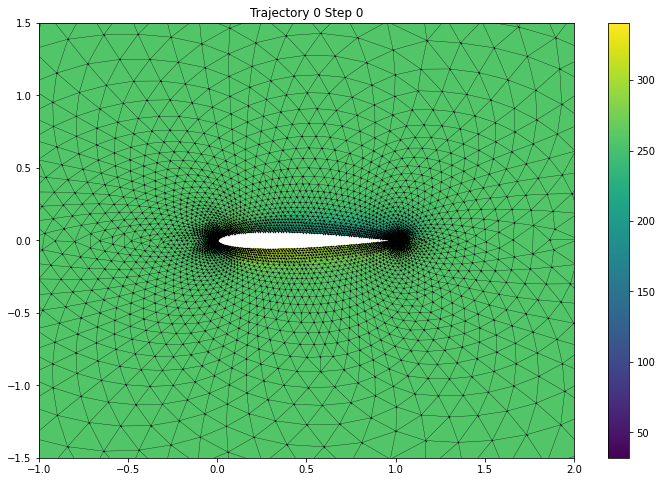

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
skip = 5
num_steps = len(res)
num_frames = num_steps // skip
# compute bounds
bounds = []

bb_min, bb_max = tf.reduce_min(qq['velocity'][:, 0]), tf.reduce_max(qq['velocity'][:, 0])


def animate(num):
    global t
    step = (num * skip) % num_steps
    traj = (num * skip) // num_steps
    ax.cla()
    ax.set_xlim(-1, 2)
    ax.set_ylim(-1.5, 1.5)
    ax.set_autoscale_on(False)
    vmin, vmax = bb_min, bb_max
    pos = qq['mesh_pos'][0]
    faces = qq['cells'][0]
    velocity = qq['velocity'][step]
    triang = mtri.Triangulation(pos[:, 0], pos[:, 1], faces)
    t = ax.tripcolor(triang, velocity[:, 0], vmin=vmin, vmax=vmax)
    ax.triplot(triang, 'ko-', ms=0.5, lw=0.3)
    ax.set_title('Trajectory %d Step %d' % (traj, step))
    return fig,


animate(0)
plt.colorbar(t)

anim = FuncAnimation(fig, animate, frames=num_frames, interval=200)
from IPython.display import HTML

HTML(anim.to_html5_video())

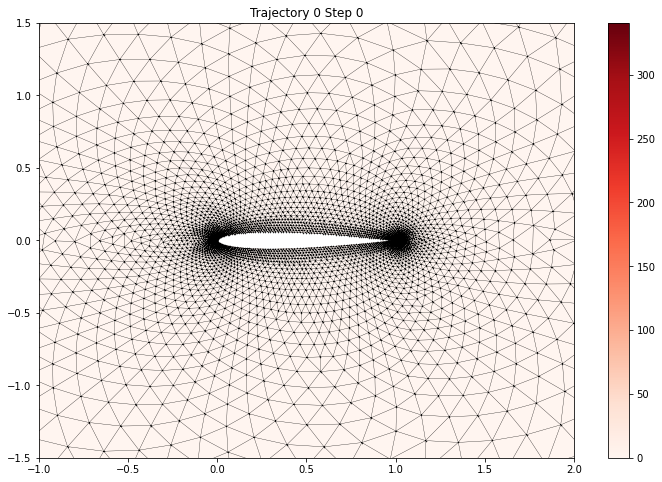

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
skip = 5
num_steps = len(res)
num_frames = num_steps // skip
# compute bounds
bounds = []

bb_min, bb_max = 0, tf.reduce_max(qq['velocity'][:, 0])


def animate(num):
    global t
    step = (num * skip) % num_steps
    traj = (num * skip) // num_steps
    ax.cla()
    ax.set_xlim(-1, 2)
    ax.set_ylim(-1.5, 1.5)
    ax.set_autoscale_on(False)
    vmin, vmax = bb_min, bb_max
    pos = qq['mesh_pos'][0]
    faces = qq['cells'][0]
    velocity = tf.math.abs(qq['velocity'][step] - res[step].nodes[..., :2])
    triang = mtri.Triangulation(pos[:, 0], pos[:, 1], faces)
    t = ax.tripcolor(triang, velocity[:, 0], vmin=vmin, vmax=vmax, cmap='Reds')
    ax.triplot(triang, 'ko-', ms=0.5, lw=0.3)
    ax.set_title('Trajectory %d Step %d' % (traj, step))
    return fig,


animate(0)
plt.colorbar(t)

anim = FuncAnimation(fig, animate, frames=num_frames, interval=200)
from IPython.display import HTML

HTML(anim.to_html5_video())

In [53]:
bb_min, bb_max

(0, <tf.Tensor: shape=(), dtype=float32, numpy=340.60352>)

In [54]:
model._node_norm._std_with_epsilon(), model._node_norm._mean()

(<tf.Tensor: shape=(5,), dtype=float32, numpy=
 array([76.54857   , 53.572285  ,  0.19159228,  0.09721107,  0.2019654 ],
       dtype=float32)>, <tf.Tensor: shape=(5,), dtype=float32, numpy=
 array([ 1.6297943e+02, -8.9823055e-01,  3.8164102e-02,  9.5410254e-03,
         9.5739484e-01], dtype=float32)>)

In [55]:
qq['target|velocity'].shape, qq['velocity'].shape

(TensorShape([599, 5233, 2]), TensorShape([599, 5233, 2]))

In [56]:
r = tf.reduce_sum((qq['velocity'] - qq['target|velocity']) ** 2)
r

<tf.Tensor: shape=(), dtype=float32, numpy=6338295.5>

In [57]:
tt = [{i: qq[i][x] for i in qq.keys()} for x in range(599)]

In [58]:
lss = []
for i in tt:
    lss.append(model.loss(toGraphsTuple(i), i))

In [59]:
lss = [x.numpy() for x in lss]

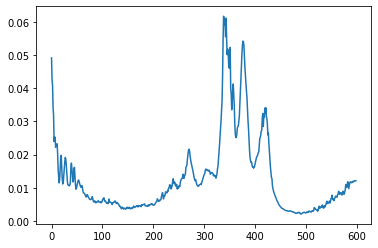

In [60]:
plt.plot(lss)

In [61]:
1e7 / (1000 * 600)

16.666666666666668

In [62]:
ee = [x.shape.as_list() for x in model.trainable_variables]
sum([(y[0] if len(y) == 1 else y[0] * y[1]) for y in ee])

2332162